In [3]:
from unittest.util import strclass
#import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  RandomizedSearchCV
from pandas.api.types import CategoricalDtype
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [4]:
train_file_path = r"data\train.csv"
test_file_path = r"data\test.csv"
test_data = pd.read_csv(test_file_path)
train_data = pd.read_csv(train_file_path)

In [5]:
test_data.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
5,1466,60,RL,75.0,10000,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
6,1467,20,RL,NaN,7980,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,500,3,2010,WD,Normal
7,1468,60,RL,63.0,8402,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
8,1469,20,RL,85.0,10176,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal
9,1470,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,4,2010,WD,Normal


In [6]:
X_train = train_data.drop(columns=["SalePrice"])
X_target = np.log1p(train_data["SalePrice"])
X_test = test_data

In [7]:
X_train, X_valid, X_train_target, X_valid_target = train_test_split(X_train,X_target,test_size=0.2, random_state=42)


In [8]:
X_train['MSZoning'] = X_train["MSZoning"].replace({'C (all)': "C"})
X_train['MSZoning'] = X_train["MSZoning"].replace({'C (all)': "C"})

Ok, let's look now more deeply into missing data and also convert categorical data
Ok, let's look now more deeply into missing data and also convert categorical data


In [9]:
X_train.select_dtypes(include=['object', 'string']).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='str')

In [10]:
#One of the most important parts related to the data we have
#Firstly I missed this part, but after running my data through model
#understood that without pandas lvls it cannot fit well as all words like
#"Po", "Fa", "TA", "Gd", "Ex" is not just simple categorical data, each represent
#how is it good or bad comparing to the others, also same with columns that has 10 levels, so we wanna say model that po<fa<ta<GG, po=0, fa=1, ta =2 and so one.
#how to decide which lvl represent each value -- read description to the data( the most annoying, but useful part)
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

#Can be done by hand adding everywhere a new value to the list of None,
#but this is faster than manual typing
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}


In [11]:
def imputer(df_train,df_valid):
    num_cols = df_train.select_dtypes(include=["int64","float64"]).columns
    cat_cols = df_train.select_dtypes(include=["object","string"]).columns

    df_train[cat_cols] = df_train[cat_cols].fillna("None")

    imputer = IterativeImputer(
        estimator=RandomForestRegressor(
            n_estimators=50,
            random_state=42,
            n_jobs=-1
        ),
        max_iter=10,
        random_state=42
    )

    imputer.fit(df_train[num_cols])

    df_train[num_cols] = imputer.transform(df_train[num_cols])
    df_valid[num_cols] = imputer.transform(df_valid[num_cols])
    return df_train,df_valid

In [12]:
X_train,X_valid = imputer(X_train,X_valid)

In [45]:
# use df[col].cat.codes to receive the level
feature_cols = X_train.select_dtypes(include=["object","string"]).columns
def encode_data(X_train):
    for column in X_train.select_dtypes(include=["object","string"]).columns:
        X_train[column] = X_train[column].astype("category")
        values_in_col = X_train[column].unique()
        print(f"Column-{column}: {values_in_col}")
    for name, levels in ordered_levels.items():
        X_train[name] = X_train[name].astype(CategoricalDtype(categories=levels,
                                                    ordered=True))
    return X_train
X_train = encode_data(X_train)
X_valid = encode_data(X_valid)

In [46]:
for col in ordered_levels.keys():
    print(f"\nColumn: {col}")
    print(dict(enumerate(X_train[col].cat.categories)))


Column: OverallQual
{0: 'None', 1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9}

Column: OverallCond
{0: 'None', 1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9}

Column: ExterQual
{0: 'None', 1: 'Po', 2: 'Fa', 3: 'TA', 4: 'Gd', 5: 'Ex'}

Column: ExterCond
{0: 'None', 1: 'Po', 2: 'Fa', 3: 'TA', 4: 'Gd', 5: 'Ex'}

Column: BsmtQual
{0: 'None', 1: 'Po', 2: 'Fa', 3: 'TA', 4: 'Gd', 5: 'Ex'}

Column: BsmtCond
{0: 'None', 1: 'Po', 2: 'Fa', 3: 'TA', 4: 'Gd', 5: 'Ex'}

Column: HeatingQC
{0: 'None', 1: 'Po', 2: 'Fa', 3: 'TA', 4: 'Gd', 5: 'Ex'}

Column: KitchenQual
{0: 'None', 1: 'Po', 2: 'Fa', 3: 'TA', 4: 'Gd', 5: 'Ex'}

Column: FireplaceQu
{0: 'None', 1: 'Po', 2: 'Fa', 3: 'TA', 4: 'Gd', 5: 'Ex'}

Column: GarageQual
{0: 'None', 1: 'Po', 2: 'Fa', 3: 'TA', 4: 'Gd', 5: 'Ex'}

Column: GarageCond
{0: 'None', 1: 'Po', 2: 'Fa', 3: 'TA', 4: 'Gd', 5: 'Ex'}

Column: PoolQC
{0: 'None', 1: 'Po', 2: 'Fa', 3: 'TA', 4: 'Gd', 5: 'Ex'}

Column: LotShape
{0: 'None', 1: 'Reg', 2: 'IR1', 3

In [16]:
#X_train[X_train['Neighborhood'] == 'NAmes']['Neighborhood']

In [17]:
def make_mi_scores(X, y, random_state=0):
    X = X.copy()

    # Encode categorical features
    for col in X.select_dtypes(include=["category"]):
        X[col], _ = X[col].factorize()

    mi = mutual_info_regression(
        X,
        y,
        discrete_features="auto",
        random_state=random_state
    )

    mi_scores = pd.Series(mi, index=X.columns, name="MI Score")
    mi_scores = mi_scores.sort_values(ascending=False)

    return mi_scores

In [20]:
mi_scores = make_mi_scores(X_train, X_train_target)
print(mi_scores)

OverallQual     0.516885
Neighborhood    0.453290
GrLivArea       0.448302
GarageArea      0.366768
GarageCars      0.357604
                  ...   
RoofMatl        0.000000
3SsnPorch       0.000000
MiscFeature     0.000000
MiscVal         0.000000
MoSold          0.000000
Name: MI Score, Length: 80, dtype: float64


In [21]:
feature_cols

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='str')

Finally I can drop columns where Mutual Information columns is equal to 0, because they don't have any impact on the predicting the price

In [22]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

In [23]:
X = drop_uninformative(X_train,mi_scores)
Y = drop_uninformative(X_valid,mi_scores)

Text(0.5, 1.0, 'Mutual Information Scores')

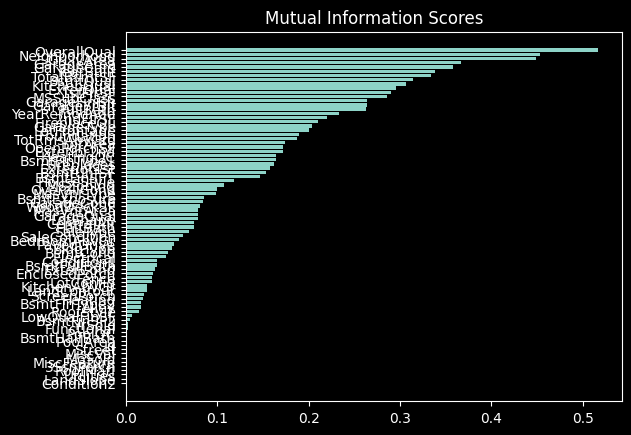

In [24]:
scores = mi_scores.sort_values(ascending=True)
width = np.arange(len(scores))
ticks = list(scores.index)
plt.barh(width, scores)
plt.yticks(width, ticks)
plt.title("Mutual Information Scores")

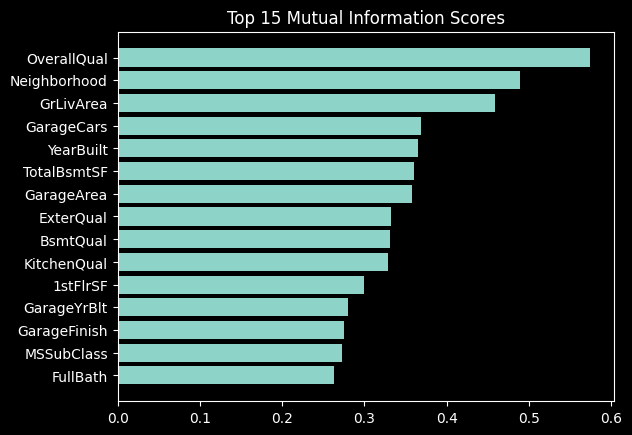

In [376]:
top_k = 15
scores = mi_scores.nlargest(top_k).sort_values()

plt.barh(scores.index, scores.values)
plt.title(f"Top {top_k} Mutual Information Scores")
plt.show()

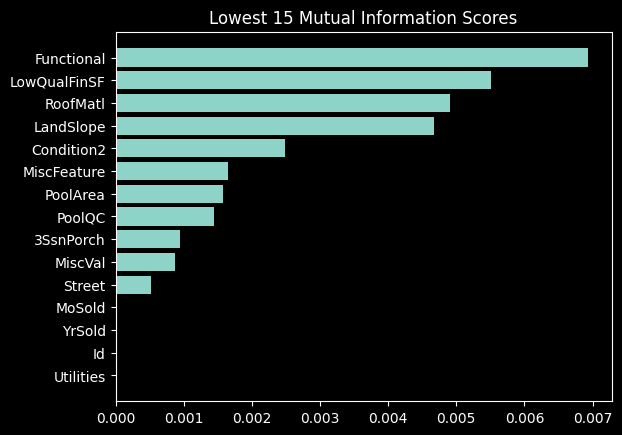

In [377]:
low_k = 15
scores = mi_scores.nsmallest(low_k)

plt.barh(scores.index, scores.values)
plt.title(f"Lowest {low_k} Mutual Information Scores")
plt.show()

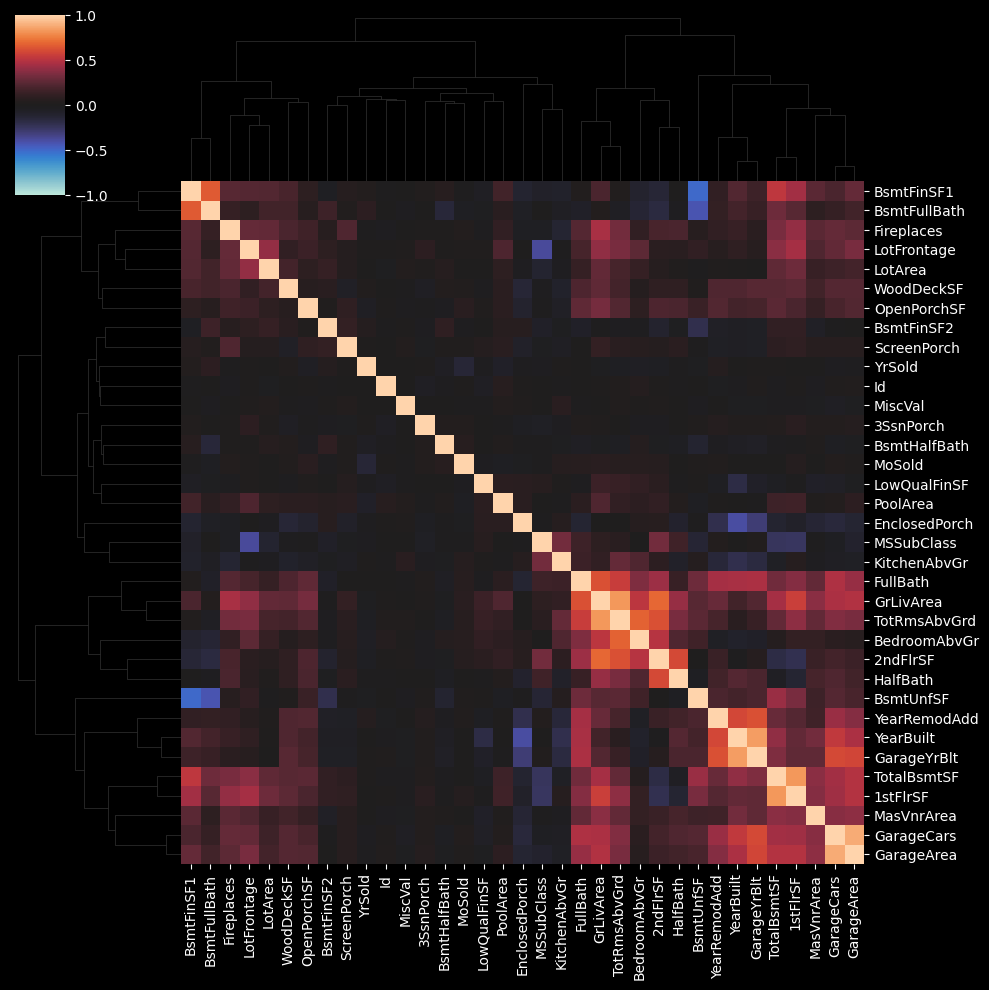

In [25]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method, numeric_only=True),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(X_train, annot=None)

In [26]:
#training based on training, for validation we predict based
#on the model that was done using only training data
def cluster_labels(df_train, df_valid, features, n_clusters=20):
    X_train = df_train.copy()
    X_valid = df_valid.copy()

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[features])
    X_valid_scaled = scaler.transform(X_valid[features])

    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=42)
    kmeans.fit(X_train_scaled)

    X_train["Cluster"] = kmeans.predict(X_train_scaled)
    X_valid["Cluster"] = kmeans.predict(X_valid_scaled)

    return X_train, X_valid

In [27]:
#my decision as all of that related to the area of the house
cluster_features = [
    "LotArea",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "GrLivArea",
    "GarageCars",
    "GarageArea"
]

In [28]:
#we are not deleting any columns from our model, avoid deleting columns after PCA or
#clustering, this will decrease accuracy
X_train, X_valid = cluster_labels(
    X_train,
    X_valid,
    cluster_features,
    n_clusters=20
)
#X_train["Cluster"] = X_train["Cluster"].astype("category")

In [29]:
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
outlier_summary = {}

for col in num_cols:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    count = ((X[col] < lower) | (X[col] > upper)).sum()
    outlier_summary[col] = count

pd.Series(outlier_summary).sort_values(ascending=False)

EnclosedPorch    160
BsmtFinSF2       131
ScreenPorch       97
MSSubClass        84
MasVnrArea        77
LotFrontage       67
BsmtHalfBath      66
OpenPorchSF       60
KitchenAbvGr      56
LotArea           54
TotalBsmtSF       47
WoodDeckSF        30
BedroomAbvGr      26
TotRmsAbvGrd      25
GrLivArea         23
BsmtUnfSF         21
LowQualFinSF      21
GarageArea        18
1stFlrSF          13
PoolArea           6
YearBuilt          5
BsmtFinSF1         5
GarageCars         4
Fireplaces         4
2ndFlrSF           1
BsmtFullBath       1
YearRemodAdd       0
GarageYrBlt        0
HalfBath           0
FullBath           0
YrSold             0
dtype: int64

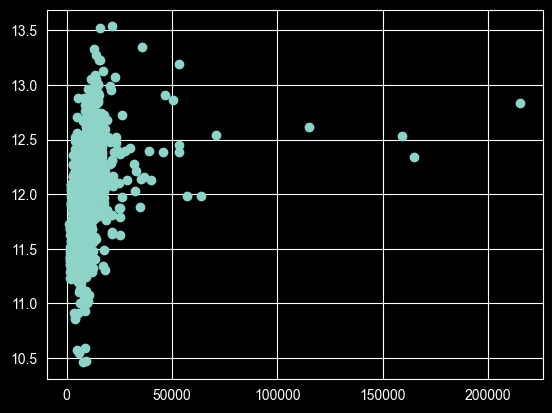

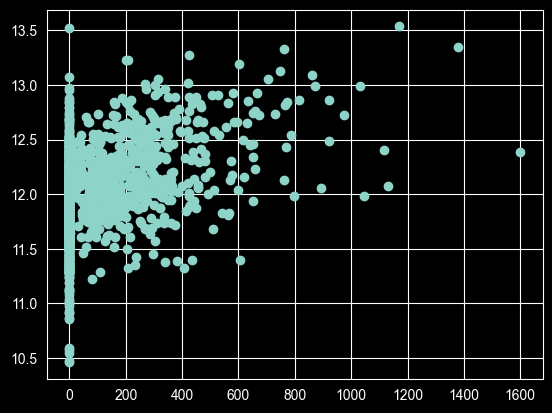

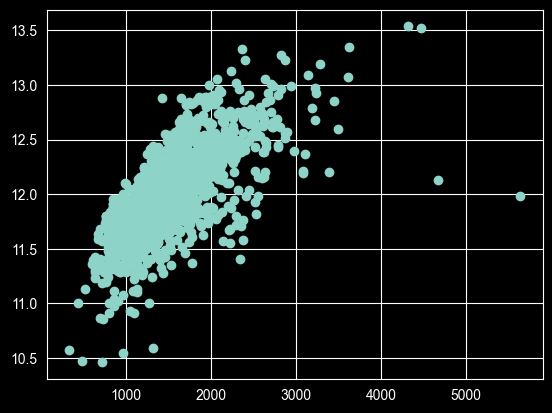

In [497]:
for col in ["LotArea", "MasVnrArea", "GrLivArea"]:
    plt.scatter(X[col], X_target)
    plt.show()

It's always good to look at outliers and data, I will not clean here any outliers, but in reality you should always be careful with outliersx, because not always deleting is the best way.
A good way is also to create simple model, find the error for each row and look at the worst cases.

In [30]:
def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

We need to encode our data, the simplest way is one-hot encoding, but we have too many parameters, so let's use target encoding.

In [31]:
X_train = label_encode(X_train)
X_valid = label_encode(X_valid)

In [32]:
model = XGBRegressor(
    random_state=42
)
#objective="reg:squaredlogerror"

For finding best hyperparams i will use scikit, but Optuna is also good option to use to find the hyperparams which fits better.

In [34]:
param_greed={
    'n_estimators':[100,200,300,500],
    'max_depth': [2,3,4,5,6], #tree level
    'learning_rate':[0.1,0.01,0.05,0.2],
    'gamma':[0.1,0.01,0.05], # gain
    'colsample_bytree':[0.5,0.75,1],
    'reg_lambda':[0,5,0.7,1],
    'reg_alpha':[0,0.01,0.1,1,10]#
}
grid_seach = RandomizedSearchCV(model,param_greed,cv=10,scoring="neg_root_mean_squared_error",n_iter=100,verbose=3,n_jobs=-1)


grid_seach.fit(X_train,X_train_target,verbose=True)

best_xgb = grid_seach.best_estimator_

print("Best params:",grid_seach.best_params_)
print("Best Score:",grid_seach.best_score_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best params: {'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.01, 'colsample_bytree': 0.75}
Best Score: -0.1259883538835555


In [39]:

best_model = grid_seach.best_estimator_

predicted_validation = best_model.predict(X_valid)
rmse = np.sqrt(mean_squared_error(X_valid_target, predicted_validation))

print("RMSE:", rmse)

RMSE: 0.13757819743023947


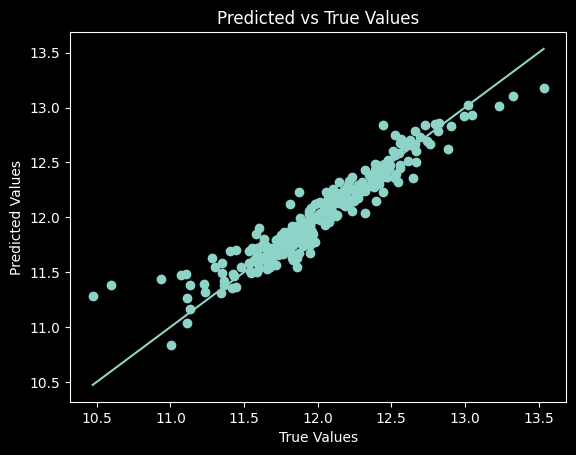

In [40]:

plt.figure()
plt.scatter(X_valid_target, predicted_validation)

# Perfect prediction line (y = x)
min_val = min(y_true.min(), predicted_validation.min())
max_val = max(y_true.max(), predicted_validation.max())
plt.plot([min_val, max_val], [min_val, max_val])

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True Values")
plt.show()

To get the result to submit in the Kaggle, make with the test data the same that was done here with validation set.

In [ ]:
#use  the inverse to convert back to real values exp(y)-1 is inverse for log(1+x)
validation_real_prediction = np.expm1(predicted_validation)